In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 81.9 MB/s eta 0:00:00


[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-27573739.py:42: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby_dataset.func[0])[condition_mask]
/tmp/ipython-input-27573739.py:42: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby_dataset.func[0])[condition_mask]
/tmp/ipython-input-27573739.py:42: FutureWarning: The 'zscore' strategy incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the 'zscore' option will be removed and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  X_all = masker.fit_transform(haxby_dataset.func[0])[condition_mask]


✅ Samples per class: {'face': np.int64(108), 'house': np.int64(108), 'scissors': np.int64(108)}
🧠 PCA Variance Retained: 97.41%

🔁 Fold 1/12
✅ Fold Accuracy: 92.59%

🔁 Fold 2/12
✅ Fold Accuracy: 100.00%

🔁 Fold 3/12
✅ Fold Accuracy: 92.59%

🔁 Fold 4/12
✅ Fold Accuracy: 85.19%

🔁 Fold 5/12
✅ Fold Accuracy: 100.00%

🔁 Fold 6/12
✅ Fold Accuracy: 96.30%

🔁 Fold 7/12
✅ Fold Accuracy: 96.30%

🔁 Fold 8/12
✅ Fold Accuracy: 92.59%

🔁 Fold 9/12
✅ Fold Accuracy: 100.00%

🔁 Fold 10/12
✅ Fold Accuracy: 96.30%

🔁 Fold 11/12
✅ Fold Accuracy: 92.59%

🔁 Fold 12/12
✅ Fold Accuracy: 88.89%

📈 Mean Accuracy: 94.44% ± 4.41%


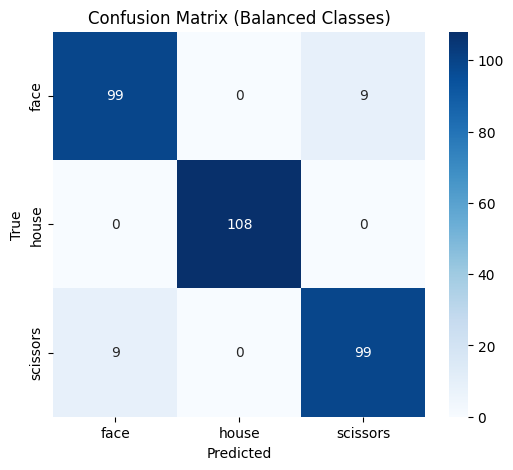

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import datasets, input_data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# ==============================
# Configuration
# ==============================
NUM_FOLDS = 12
PCA_COMPONENTS = 150
SAMPLES_PER_CLASS = 108

categories = ['face', 'house', 'scissors']

# ==============================
# Load Haxby Dataset
# ==============================
haxby_dataset = datasets.fetch_haxby()
mask_filename = haxby_dataset.mask_vt[0]

labels_df = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
condition_mask = labels_df['labels'].isin(categories)

conditions = labels_df[condition_mask].reset_index(drop=True)
labels = conditions['labels'].values

# ==============================
# fMRI Masking
# ==============================
masker = input_data.NiftiMasker(
    mask_img=mask_filename,
    standardize=True
)

X_all = masker.fit_transform(haxby_dataset.func[0])[condition_mask]

# ==============================
# BALANCE CLASSES (108 per class)
# ==============================
X_balanced = []
y_balanced = []

for i, cat in enumerate(categories):
    idx = np.where(labels == cat)[0][:SAMPLES_PER_CLASS]
    X_balanced.append(X_all[idx])
    y_balanced.append(np.full(SAMPLES_PER_CLASS, i))

X_balanced = np.vstack(X_balanced)
y_balanced = np.concatenate(y_balanced)

print("✅ Samples per class:", {cat: np.sum(y_balanced == i) for i, cat in enumerate(categories)})

# ==============================
# Standardization + PCA
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"🧠 PCA Variance Retained: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# ==============================
# SVM Cross-Validation
# ==============================
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_accuracies = []
y_preds, y_trues = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
    print(f"\n🔁 Fold {fold+1}/{NUM_FOLDS}")

    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

    # Create and train SVM
    svm_model = SVC(kernel='rbf', C=0.5, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Evaluate
    y_pred = svm_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    y_preds.extend(y_pred)
    y_trues.extend(y_test)

    print(f"✅ Fold Accuracy: {acc * 100:.2f}%")

# ==============================
# Results
# ==============================
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)

print(f"\n📈 Mean Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_trues, y_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Balanced Classes)")
plt.show()


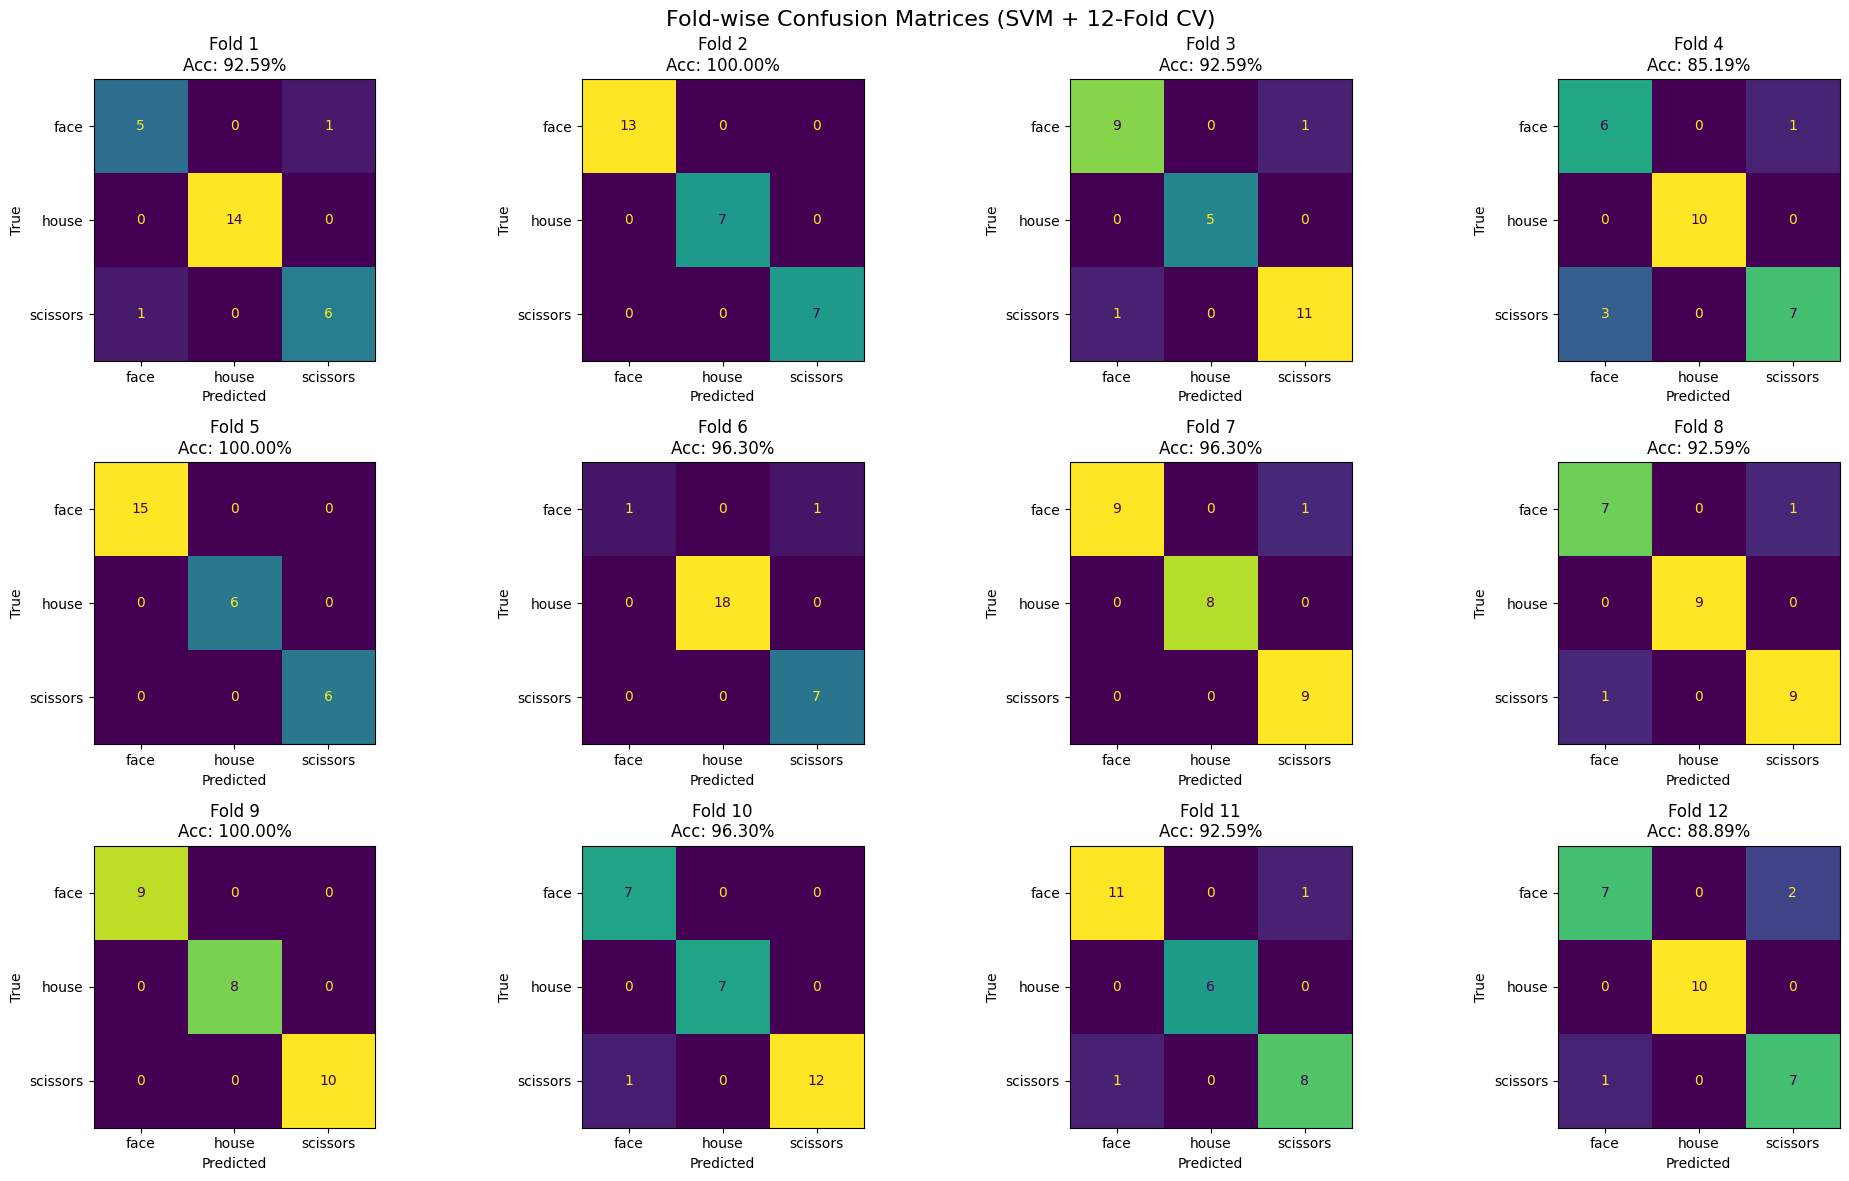

In [8]:
# ==============================
# Fold-wise Confusion Matrices
# ==============================
from sklearn.metrics import ConfusionMatrixDisplay
import math

fold_confusion_matrices = []

num_folds = NUM_FOLDS
cols = 4
rows = math.ceil(num_folds / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

    # Train SVM
    svm_model = SVC(kernel='rbf', C=0.5, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred = svm_model.predict(X_test)

    # Confusion Matrix
    cm_fold = confusion_matrix(y_test, y_pred, labels=np.arange(len(categories)))
    fold_confusion_matrices.append(cm_fold)

    # Display on subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_fold, display_labels=categories)
    disp.plot(ax=axes[fold], colorbar=False)
    axes[fold].set_title(f"Fold {fold+1}\nAcc: {accuracy_score(y_test, y_pred)*100:.2f}%")
    axes[fold].set_xlabel("Predicted")
    axes[fold].set_ylabel("True")

# Remove unused axes
for j in range(num_folds, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Fold-wise Confusion Matrices (SVM + 12-Fold CV)", fontsize=16)
plt.tight_layout()
plt.show()


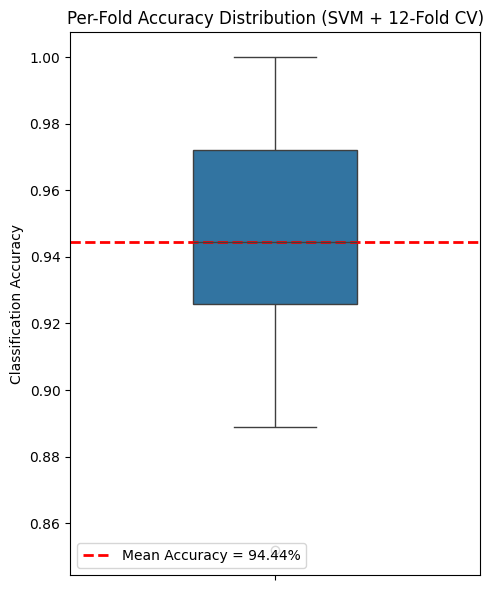

In [9]:
# -----------------------------
# Box plot of per-fold accuracy
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# fold_accuracies is already collected during CV
fold_accuracies = np.array(fold_accuracies)  # ensure it's a NumPy array

plt.figure(figsize=(5, 6))

sns.boxplot(
    y=fold_accuracies,
    width=0.4,
    showfliers=True
)

# Mean accuracy (dotted red line)
mean_acc = np.mean(fold_accuracies)
plt.axhline(
    mean_acc,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean Accuracy = {mean_acc*100:.2f}%"
)

plt.ylabel("Classification Accuracy")
plt.title("Per-Fold Accuracy Distribution (SVM + 12-Fold CV)")
plt.legend()
plt.tight_layout()
plt.show()



================ MISCLASSIFICATION SUMMARY ================
Total Samples           : 324
Correctly Classified    : 306
Misclassified Samples   : 18
Overall Accuracy        : 94.44%

📊 Per-Class Prediction Summary:
      Class  True Positives  False Positives  False Negatives  True Negatives
0      face              99                9                9             207
1     house             108                0                0             216
2  scissors              99                9                9             207

❌ Misclassification Details:
  True Class Predicted As  Count
0       face     scissors      9
1   scissors         face      9


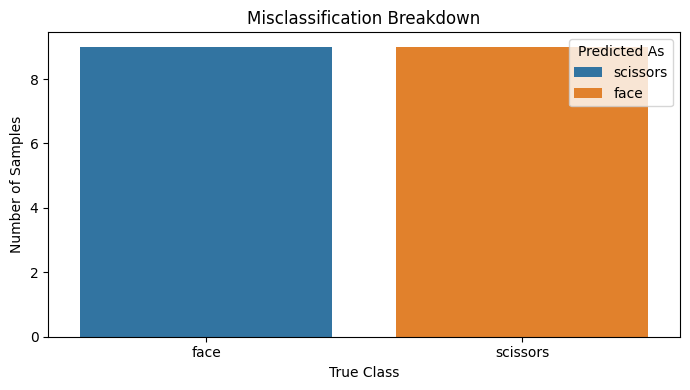

In [12]:
# =====================================================
# Misclassification Summary
# =====================================================

import pandas as pd
import numpy as np

cm = confusion_matrix(y_trues, y_preds)

total_samples = np.sum(cm)
correct_predictions = np.trace(cm)
misclassified = total_samples - correct_predictions

print("\n================ MISCLASSIFICATION SUMMARY ================")
print(f"Total Samples           : {total_samples}")
print(f"Correctly Classified    : {correct_predictions}")
print(f"Misclassified Samples   : {misclassified}")
print(f"Overall Accuracy        : {correct_predictions / total_samples * 100:.2f}%")

# -----------------------------------------------------
# Per-class breakdown
# -----------------------------------------------------
summary = []

for i, cls in enumerate(categories):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = total_samples - (TP + FP + FN)

    summary.append({
        "Class": cls,
        "True Positives": TP,
        "False Positives": FP,
        "False Negatives": FN,
        "True Negatives": TN
    })

summary_df = pd.DataFrame(summary)

print("\n📊 Per-Class Prediction Summary:")
print(summary_df)

# -----------------------------------------------------
# Detailed Misclassification Pairs
# -----------------------------------------------------
misclass_details = []

for i, true_class in enumerate(categories):
    for j, pred_class in enumerate(categories):
        if i != j and cm[i, j] > 0:
            misclass_details.append({
                "True Class": true_class,
                "Predicted As": pred_class,
                "Count": cm[i, j]
            })

misclass_df = pd.DataFrame(misclass_details)

print("\n❌ Misclassification Details:")
print(misclass_df if not misclass_df.empty else "No misclassifications")

# -----------------------------------------------------
# Optional: Visual bar chart of misclassifications
# -----------------------------------------------------
if not misclass_df.empty:
    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=misclass_df,
        x="True Class",
        y="Count",
        hue="Predicted As"
    )
    plt.title("Misclassification Breakdown")
    plt.ylabel("Number of Samples")
    plt.xlabel("True Class")
    plt.tight_layout()
    plt.show()


[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-327545185.py:46: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]
/tmp/ipython-input-327545185.py:46: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]
/tmp/ipython-input-327545185.py:46: FutureWarning: The 'zscore' strategy incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the 'zscore' option will be removed and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]



🔹 Pairwise Classification: face vs house
✅ Samples per class: 108
🧠 PCA variance retained: 98.79%
  Fold 1: 100.00%
  Fold 2: 100.00%
  Fold 3: 94.44%
  Fold 4: 100.00%
  Fold 5: 100.00%
  Fold 6: 100.00%
  Fold 7: 100.00%
  Fold 8: 100.00%
  Fold 9: 100.00%
  Fold 10: 100.00%
  Fold 11: 100.00%
  Fold 12: 100.00%
📈 Mean Accuracy: 99.54% ± 1.54%


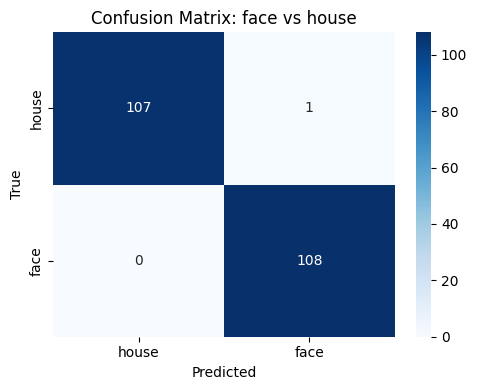

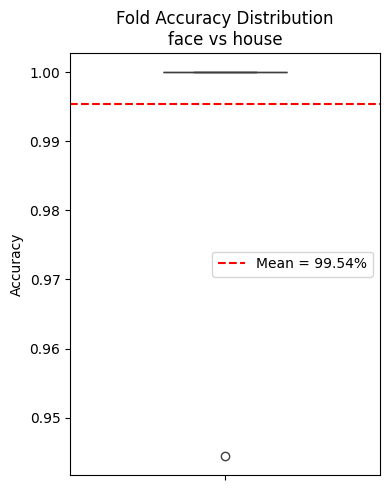


🔹 Pairwise Classification: face vs scissors
✅ Samples per class: 108
🧠 PCA variance retained: 98.80%
  Fold 1: 94.44%
  Fold 2: 94.44%
  Fold 3: 88.89%
  Fold 4: 83.33%
  Fold 5: 100.00%
  Fold 6: 94.44%
  Fold 7: 88.89%
  Fold 8: 94.44%
  Fold 9: 77.78%
  Fold 10: 72.22%
  Fold 11: 94.44%
  Fold 12: 100.00%
📈 Mean Accuracy: 90.28% ± 8.22%


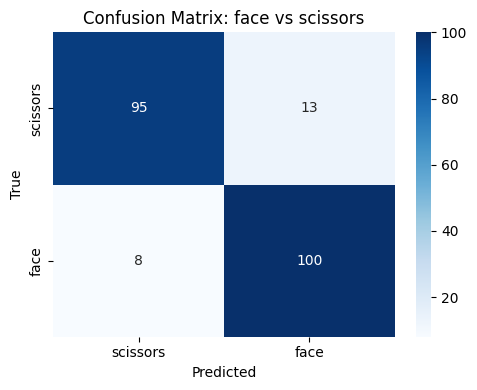

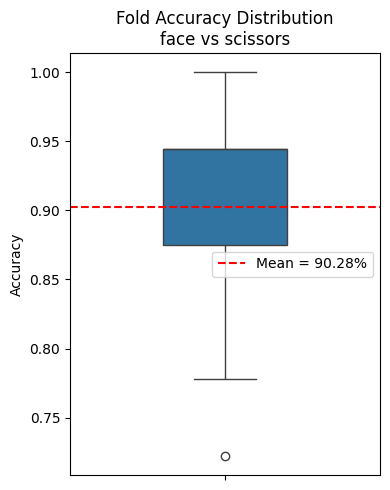


🔹 Pairwise Classification: house vs scissors
✅ Samples per class: 108
🧠 PCA variance retained: 98.78%
  Fold 1: 100.00%
  Fold 2: 100.00%
  Fold 3: 100.00%
  Fold 4: 100.00%
  Fold 5: 100.00%
  Fold 6: 100.00%
  Fold 7: 100.00%
  Fold 8: 100.00%
  Fold 9: 100.00%
  Fold 10: 100.00%
  Fold 11: 100.00%
  Fold 12: 100.00%
📈 Mean Accuracy: 100.00% ± 0.00%


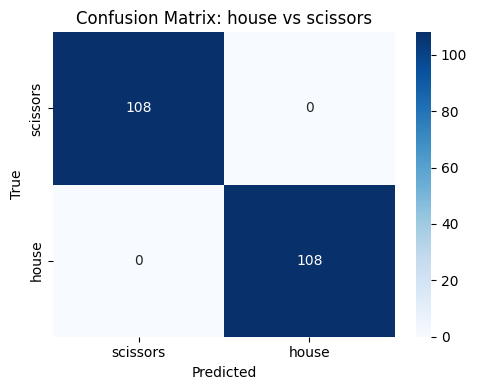

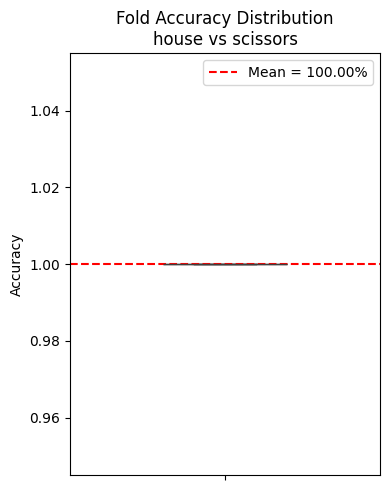


================ Pairwise Summary =================
face vs house: 99.54% ± 1.54%
face vs scissors: 90.28% ± 8.22%
house vs scissors: 100.00% ± 0.00%


In [10]:
# ============================================================
# Pairwise Classification on Haxby Dataset (PCA + SVM)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from nilearn import datasets, input_data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations

# ==============================
# Configuration
# ==============================
NUM_FOLDS = 12
PCA_COMPONENTS = 150
SAMPLES_PER_CLASS = 108
categories = ['face', 'house', 'scissors']

# ==============================
# Load Haxby Dataset
# ==============================
haxby = datasets.fetch_haxby()
mask_filename = haxby.mask_vt[0]

labels_df = pd.read_csv(haxby.session_target[0], sep=' ')
condition_mask = labels_df['labels'].isin(categories)

labels = labels_df.loc[condition_mask, 'labels'].values

# ==============================
# fMRI Masking
# ==============================
masker = input_data.NiftiMasker(
    mask_img=mask_filename,
    standardize=True
)

X_all = masker.fit_transform(haxby.func[0])[condition_mask]

# ============================================================
# Pairwise Classification Function
# ============================================================
def run_pairwise_classification(X, labels, class_a, class_b):
    print(f"\n🔹 Pairwise Classification: {class_a} vs {class_b}")

    # Select pair
    mask = np.isin(labels, [class_a, class_b])
    X_pair = X[mask]
    y_pair = labels[mask]

    # Binary labels
    y_pair = (y_pair == class_a).astype(int)

    # Balance classes
    min_samples = min(np.sum(y_pair == 0), np.sum(y_pair == 1))
    idx0 = np.where(y_pair == 0)[0][:min_samples]
    idx1 = np.where(y_pair == 1)[0][:min_samples]

    idx = np.concatenate([idx0, idx1])
    X_pair = X_pair[idx]
    y_pair = y_pair[idx]

    print(f"✅ Samples per class: {min_samples}")

    # Standardization + PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pair)

    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"🧠 PCA variance retained: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

    # Cross-validation
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    fold_accuracies = []
    y_preds, y_trues = [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
        svm = SVC(kernel='rbf', C=0.5, gamma='scale')
        svm.fit(X_pca[train_idx], y_pair[train_idx])

        y_pred = svm.predict(X_pca[test_idx])
        acc = accuracy_score(y_pair[test_idx], y_pred)

        fold_accuracies.append(acc)
        y_preds.extend(y_pred)
        y_trues.extend(y_pair[test_idx])

        print(f"  Fold {fold+1}: {acc*100:.2f}%")

    # Results
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    print(f"📈 Mean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_trues, y_preds)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[class_b, class_a],
        yticklabels=[class_b, class_a]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {class_a} vs {class_b}")
    plt.tight_layout()
    plt.show()

    # Box plot of fold accuracies
    plt.figure(figsize=(4, 5))
    sns.boxplot(y=fold_accuracies, width=0.4)
    plt.axhline(mean_acc, color='red', linestyle='--',
                label=f"Mean = {mean_acc*100:.2f}%")
    plt.ylabel("Accuracy")
    plt.title(f"Fold Accuracy Distribution\n{class_a} vs {class_b}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mean_acc, std_acc

# ============================================================
# Run all pairwise classifications
# ============================================================
pairwise_results = {}

pairs = list(combinations(categories, 2))

for class_a, class_b in pairs:
    mean_acc, std_acc = run_pairwise_classification(
        X_all, labels, class_a, class_b
    )
    pairwise_results[f"{class_a} vs {class_b}"] = (mean_acc, std_acc)

# ============================================================
# Summary
# ============================================================
print("\n================ Pairwise Summary =================")
for pair, (mean_acc, std_acc) in pairwise_results.items():
    print(f"{pair}: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
